# Tracking Depression and Suicidal Ideation in Social Media
### Analysis and Dashboarding for tracking features associated with mental health risk
## Part 3 - Text Classification; Suicidal ideation posts vs other mental health posts

### Table of Contents

* <a href='#Part_1'> Abstract</a> 
* <a href='#Part_2'> Obtain & Scrub</a>   
* <a href='#Part_3'> Model Training/Testing</a> 
* <a href='#Part_4'> Hyperparameter Optimization</a>
* <a href='#Part_5'> Final Model</a>
* <a href='#Part_6'> Conclusions</a>

In [367]:
#Importing Libraries
import requests
import nltk
import json
import time
import pandas as pd
import numpy as np
import re
import praw
import prawcore
import datetime as dt
import matplotlib.pyplot as plt
import scipy
import pymongo
import functions as functions
import os
import patsy as py
import seaborn as sns
import itertools
import xgboost as xgb
import tensorflow
import sklearn
import keras_metrics
import shap
import pickle

from importlib import reload
from numpy import mean, var
from math import sqrt
from os import path
from pymongo import MongoClient, errors
from pymongo.errors import InvalidDocument
from patsy import dmatrices
from textblob import TextBlob

from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus.reader.wordnet import ADJ, ADJ_SAT, ADV, NOUN
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn import preprocessing, svm, tree, model_selection
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score,precision_recall_fscore_support, auc
from sklearn.metrics import f1_score, confusion_matrix, make_scorer, classification_report, roc_auc_score, SCORERS
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier                          
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer


from xgboost import XGBClassifier, plot_importance
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from gensim.models import Word2Vec
from treeinterpreter import treeinterpreter as ti
from shap import TreeExplainer

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras_metrics import f1_score
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, Input, Dense, LSTM, GRU, Embedding
from keras import optimizers
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Dropout, Activation, Conv1D, MaxPooling1D
from keras.layers import GlobalMaxPool1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, Nadam
from keras.activations import relu, elu
from keras.losses import categorical_crossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import initializers, regularizers, constraints, optimizers, layers

from functions import connect_to_reddit, connect_to_mongo, get_stem_abs, get_stop_words, text_cleaner, get_date;
from functions import submissions_to_mongo, clean_df, get_tot_word, get_abs_word_count, get_perc_abs, cohend;
from functions import get_abs_chart, get_post_distribution, wordcloud, clean_text, get_distribution, get_word_freq;
from functions import evaluate, plot_confusion_matrix, get_authors, get_author_posts, check_exists, mongo_to_df;


os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [222]:
#connecting to mongo database
client = connect_to_mongo()
# connecting to reddit api
reddit = connect_to_reddit()

now connected to mongo
pillosoft connecting to reddit API


<a id='Part_1'></a>

# Abstract

Now that we can classify posts belonging to those on social media who self-identify as anxious, depressed or suicidal (based on their involvement in those forums) versus regular posters related to chronic diseases and/or hobbies, it would add additional value to clinicians if we could classify a distinction between mental health posters who are experiencing suicial ideation versus those social media posters who are depressed/anxious but are not experiencing suicidal ideation. 

If we can build a functioning classifier based on the limited, web-scraped data that we have, it would be extremely beneficial to both clinicians and loved ones alike who are concerned about the progress of a mental health patient under their care.

In this section, we will take all the posts from all over reddit from those who have posted in the suicide forum at one point, and build a classifier that can identify their posts versus authors who have posted in other mental health type forums. Taking all of these authors' posts from all over reddit helps to generalize the data a bit more, so we can use the language of a poster who isn't just necessarily talking about suicidal ideation in a suicide-specific reddit forum, but we can also look at their language across all other forums that they have posted in, to see if we can identify any overall patterns in text.

In [223]:
abs_word_list = ['absolutely', 'all', 'always', 'complete', 'completely', 'constant', 'constantly', 'definitely', 
                 'entire', 'ever', 'every', 'everyone', 'everything', 'full', 'must', 'never', 'nothing', 
                 'totally', 'whole']

remove_words = ["http", "https", "www", "com", "reddit", "jpg", 'x', 'b', 'f', 'r', 'c', 'd', 'e', 'f', 
               'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'op', 'q', 's', 't', 'u', 'v', 'w', 'y', 'z',
               '00', '01', '04', '10', '100', '1000', '1000mg', '100mg', '100x', '108', '10k', '10lbs', 
                '10pm', '10th', '10yo', '10yrs', '11', '119', '11am', '11d', '11th', '12', '120', '12g', 
                '12ga', '12ish', '13', '14', '140', '146', '15', '150', '150mg', '1549449839413', '15min', 
                '16', '160', '162', '16f', '16y', '17', '170', '17f', '17th', '17yo', '18', '180', '189', 
                '18months', '18th', '19', '1950', '1974', '1996', '19o', '19th', '1drl', '1k', '1mg', '1st', 
                '1x', '20', '200', '2000', '2003', '2007', '200mg', '2010', '2012', '2014', '2015', '2016', 
                '2017', '2018', '2019', '20mg', '20oz', '20th', '21', '215lbs', '22', '22m', '23', '2300', 
                '23andme', '24', '24hrs', '25', '250', '2500', '250mg', '258', '25mg', '25th', '26', '260lbs', 
                '26yo', '27', '270', '27th', '27year', '28', '28th', '29', '2ahukewiuracn9kbgahvb6kqkhy2ld', 
                '2am', '2l', '2lbs', '2mo', '2nd', '2wks', '2x', '2years', '2yrs', '30', '300', '3000', 
                '3000mg', '300mg', '304', '30th', '31', '310', '31st', '32', '325mg', '32oz', '33', '34', 
                '340', '35', '350', '357', '37', '38', '39', '3am', '3lb', '3mg', '3pm', '3rd', '3rds', '40', 
                '400', '40cl', '40km', '40lbs', '40mg', '40s', '40th', '42', '43m', '44', '45', '450', '48', 
                '48oz', '49', '4am', '4th', '50', '500', '500mg', '50mcg', '50mg', '50oz', '50s', '5150', '5600',
                '5677676', '57', '5k', '5mg', '5pm', '5th', '60', '600', '600mg', '60k', '61', '63', '64', '6am',
                '6mg', '6th', '6yrs', '70', '700', '70cl', '70s', '72', '75mg', '79558b7f', '7pm', '7t4ngdpbitq',
                '7th', '80', '800', '8th', '90', '92', '95', '99', '9am', '9th', '___', '_a', '_anyone', '_be',
                '_food', '_for', '_in', '_interested', '_me', '_tracker', 'aa', 'aans', 'like']

pre_stop_words = list(stopwords.words("english"))

moderators = ['S2S2S2S2S2','Psy-Kosh','SicSemperHumanus','SQLwitch','UnDire','pkbooo','skyqween','MykeeB',
              'circinia','svneko','MuffinMedic','remyschnitzel','vodkalimes','dwade333miami','anxietymods',
              'BotBust','MrZalarox','Pi25','analemmaro', 'abhava-sunya','sofar1776','AccioInternets','palisade2621',
              'Hermiones_Teaspoon','AweBeyCon','dancingonfire','midnightdragon','elbowsss','Chefjones','pezes',
              'sulkee','Greypo','exoendo','Jakeable','MeghanAM','JoyousCacophony','hansjens47','Qu1nlan',
              'english06','samplebitch','optimalg','rhiever','Geographist','frostickle','NonNonHeinous',
              'Vizual-Statistix','sarahbotts','zonination','spermface','yelper','mungoflago','ostedog','rsrsrsrs',
              'townie_immigrant','JoeAllan','theReluctantHipster','AutoModerator', 'iimsorryy','wanderlusterer',
              'awaxa','dosman711','mmccullen','Ariensus','turtletechnology','cascer1','cluckj','adidushi',
              'Muffinzz','IHaveTheBestCandy','crilen','Cerenkov_Blue', 'binarysneaker','vomita_conejitos','polezo']

subreddit_list = ['suicidewatch', 'depression', 'anxiety',
                  'diabetes', 'heartdisease', 'gout', 'copd',
                  'travel', 'basketball', 'harrypotter']

stem_abs = get_stem_abs(abs_word_list)

stop_words = get_stop_words(remove_words, abs_word_list, pre_stop_words)

stop words list length is now:
179
adding words from include list
new words have been added, stop words list length is now:
429
removing exlude words
exclude list words removed. stop words length is now:
428


<a id='Part_2'></a>

# Obtain & Scrub

In [224]:
# accessing collections
reddit_db = client["reddit"]
reddit_submissions = reddit_db['submissions_for_author_analysis']
suicide_redditors = reddit_db['suicide']
dep_redditors = reddit_db['dep']
anx_redditors = reddit_db['anx']
gout_redditors = reddit_db['gout']
db_redditors = reddit_db['db']
copd_redditors = reddit_db['copd']
htn_redditors = reddit_db['htn']
trav_redditors = reddit_db['travel']
bb_redditors = reddit_db['bb']
hp_redditors = reddit_db['hp']

In [225]:
# converting mongo db collections to dataframes
suicide_df, anx_df, dep_df, gout_df, htn_df, copd_df, db_df, travel_df, bb_df, hp_df = (None,)*10
suicide_df = mongo_to_df(suicide_df, suicide_redditors)
anx_df = mongo_to_df(anx_df, anx_redditors)
dep_df = mongo_to_df(dep_df, dep_redditors)
gout_df = mongo_to_df(gout_df, gout_redditors)
htn_df = mongo_to_df(htn_df, htn_redditors)
copd_df = mongo_to_df(copd_df, copd_redditors)
db_df = mongo_to_df(db_df, db_redditors)
travel_df = mongo_to_df(travel_df, trav_redditors)
bb_df = mongo_to_df(bb_df, bb_redditors)
hp_df = mongo_to_df(hp_df, hp_redditors)

In [411]:
# suicide reddit forum authors only, using the same authors' posts over all of reddit:
s_df = suicide_df
s_df.drop_duplicates(subset='cleaned_text', inplace=True)

# anxiety/depression forum authors only, using the same authors' posts over all of reddit:
df = pd.concat([anx_df, dep_df])
df.drop_duplicates(subset='cleaned_text', inplace=True)

# excluding those who are in the anxiety/depression group who have posted in the suicide forum:
df = df[df.subreddit != 'SuicideWatch']

# random sample to even out the groups:
df = df.sample(n=2750)

# labeling the groups
df['labels'] = 0 # 0: Not suicidal
s_df['labels'] = 1 # 1: suicidal
print('Example of the first 50 forums in the list of forums data was scraped from:')
print("")
print(df.subreddit.unique()[0:50], '...')

Example of the first 50 forums in the list of forums data was scraped from:

['Anxiety' 'SmiteLFM' 'depression_help' 'Swimming' 'selfharm' 'opiates'
 'depression' 'Music' 'relationships' 'Stims' 'offmychest' 'piano'
 'macbookpro' 'AskDocs' 'cocaine' 'CrohnsDisease' 'Purdue'
 'KitchenConfidential' 'grime' 'Borderlands' 'careerguidance'
 'AnxietyDepression' 'teenagers' 'LilPeep' 'MechanicAdvice'
 'unpopularopinion' 'NoFap' 'ACT' 'TheCloneWars' 'TalesFromYourBarista'
 'fireTV' 'Bowling' 'leagueoflegends' 'BeardedDragons' 'vegan1200isplenty'
 'MultipleSclerosis' 'Choices' 'Lowes' 'Staples' 'dysautonomia'
 'prisonarchitect' 'verizon' 'crochet' 'datascience' 'storyofseasons'
 'tipofmytongue' 'ExNoContact' 'CreditCards' 'skyrim' 'podcasts'] ...


In [412]:
print('Example of the first 50 forums in the list of forums data was scraped from:')
print("")
print(s_df.subreddit.unique()[0:50], '...')

Example of the first 50 forums in the list of forums data was scraped from:

['SuicideWatch' 'offmychest' 'relationships' 'Advice' 'ftm' 'FTMMen'
 'selfimprovement' 'rapecounseling' 'MakeNewFriendsHere' 'tipofmytongue'
 'OntarioUniversities' 'FriendshipAdvice' 'NoFap' 'bipolar2' 'addiction'
 'FreeCompliments' 'Petloss' 'Esthetics' 'Psychic' 'migraine'
 'thyroidhealth' 'acne' 'cats' 'KingdomHearts' 'tales' 'Twitch' 'crochet'
 'techsupport' 'HaircareScience' 'BreadTube' 'googleplaymusic' 'dxm' 'DPH'
 'Drugs' 'lonely' 'XboxOneGamers' 'Needafriend' 'selfharm' 'depression'
 'ForeverAlone' 'Anxiety' 'Christianity' 'pornfree' 'Psychosis'
 'Nootropics' 'PlasticSurgery' 'diabetes' 'Peptides' 'phenibut'
 'MemantineHCl'] ...


In [248]:
#joining the dataframes 
final_df = pd.concat([s_df, df])
#dropping duplicates
final_df.drop_duplicates(subset='cleaned_text', inplace=True)
class_names = set(final_df.labels)

<a id='Part_3'></a>

# Model Training/Testing

In [228]:
# train test split:
X_train, X_test, y_train, y_test = train_test_split(final_df.cleaned_text, final_df.labels, 
                                                    train_size=0.65, test_size=0.35)

### 1. Logistic Regression Classifier 

Logistic Regression Results

Training Precision:  0.8723041997729852
Testing Precision:  0.6745435016111708



Training Recall:  0.8629983155530601
Testing Recall:  0.6434426229508197



Training Accuracy:  0.8671764372698952
Testing Accuracy:  0.6577287066246057



Training F1 Score:  0.8676263053909116
Testing F1 Score:  0.6586261143156792



Confusion matrix, without normalization


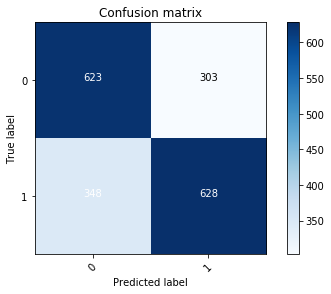




Normalized confusion matrix


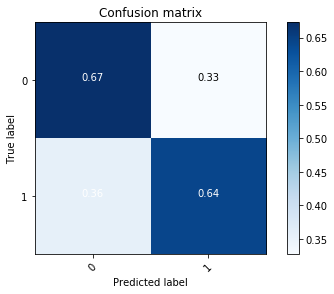

In [229]:
# Utilizing pipelines to Count Vectorize, TF-IDF transform, and run the classifier:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression()),])
text_clf.fit(X_train, y_train)
predicted_test = text_clf.predict(X_test)
predicted_train = text_clf.predict(X_train)
print("Logistic Regression Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

### 2. Random Forest Classifier 

Random Forest Results

Training Precision:  0.9931467732724157
Testing Precision:  0.6334563345633456



Training Recall:  0.9764177428411005
Testing Recall:  0.5276639344262295



Training Accuracy:  0.9847068819031436
Testing Accuracy:  0.6009463722397477



Training F1 Score:  0.9847112117780294
Testing F1 Score:  0.5757406372275015



Confusion matrix, without normalization


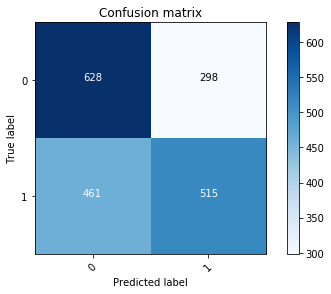




Normalized confusion matrix


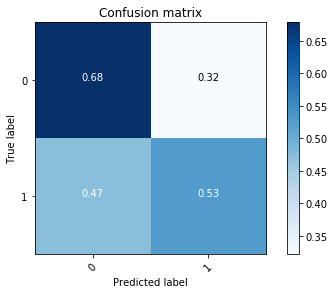

In [230]:
# Utilizing pipelines to Count Vectorize, TF-IDF transform, and run the classifier:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier()),])
text_clf.fit(X_train, y_train)
predicted_test = text_clf.predict(X_test)
predicted_train = text_clf.predict(X_train)
print("Random Forest Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

### 3. Adaboost

Adaboost Results

Training Precision:  0.7449814126394052
Testing Precision:  0.6540027137042063



Training Recall:  0.562605277933745
Testing Recall:  0.49385245901639346



Training Accuracy:  0.6822429906542056
Testing Accuracy:  0.6062039957939012



Training F1 Score:  0.6410748560460652
Testing F1 Score:  0.5627553998832459



Confusion matrix, without normalization


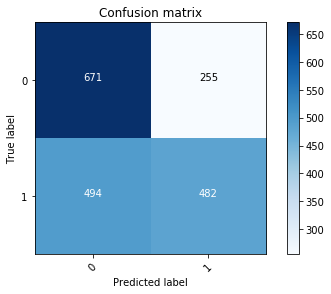




Normalized confusion matrix


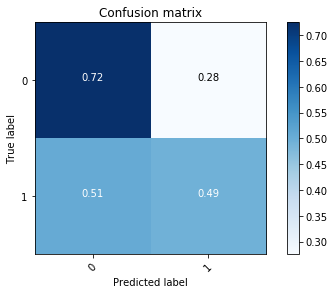

In [231]:
# Utilizing pipelines to Count Vectorize, TF-IDF transform, and run the classifier:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', AdaBoostClassifier()),])
text_clf.fit(X_train, y_train)
predicted_test = text_clf.predict(X_test)
predicted_train = text_clf.predict(X_train)
print("Adaboost Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

### 4. Gradient Boosting 

Gradient Boosting Results

Training Precision:  0.8439226519337016
Testing Precision:  0.6567695961995249



Training Recall:  0.6861313868613139
Testing Recall:  0.5665983606557377



Training Accuracy:  0.777683375814217
Testing Accuracy:  0.6256572029442692



Training F1 Score:  0.7568906782285538
Testing F1 Score:  0.6083608360836082



Confusion matrix, without normalization


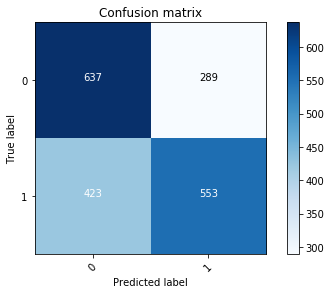




Normalized confusion matrix


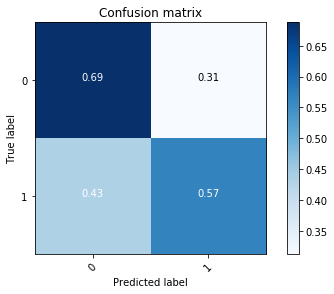

In [232]:
# Utilizing pipelines to Count Vectorize, TF-IDF transform, and run the classifier:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', GradientBoostingClassifier()),])
text_clf.fit(X_train, y_train)
predicted_test = text_clf.predict(X_test)
predicted_train = text_clf.predict(X_train)
print("Gradient Boosting Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

### 5. XGB Classifier 

XGBoost Results

Training Precision:  0.8406754772393539
Testing Precision:  0.6612090680100756



Training Recall:  0.6428972487366648
Testing Recall:  0.5379098360655737



Training Accuracy:  0.7584253752478052
Testing Accuracy:  0.6214511041009464



Training F1 Score:  0.7286032453070315
Testing F1 Score:  0.5932203389830508



Confusion matrix, without normalization


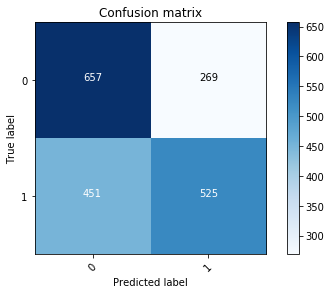




Normalized confusion matrix


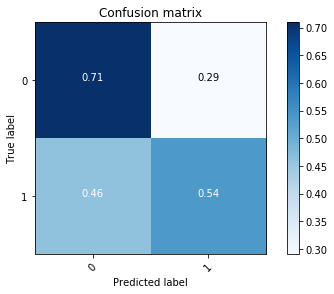

In [233]:
# Utilizing pipelines to Count Vectorize, TF-IDF transform, and run the classifier:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', XGBClassifier()),])
text_clf.fit(X_train, y_train)
predicted_test = text_clf.predict(X_test)
predicted_train = text_clf.predict(X_train)
print("XGBoost Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

### 6. SGD Classifier

Stochastic Gradient Descent Results

Training Precision:  0.958803611738149
Testing Precision:  0.6637744034707158



Training Recall:  0.9539584503088153
Testing Recall:  0.6270491803278688



Training Accuracy:  0.9561030869442084
Testing Accuracy:  0.6456361724500526



Training F1 Score:  0.9563748944553899
Testing F1 Score:  0.6448893572181243



Confusion matrix, without normalization


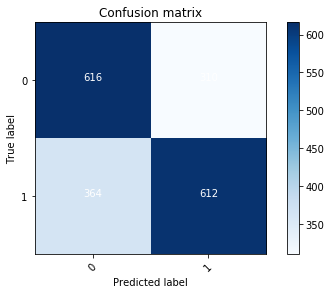




Normalized confusion matrix


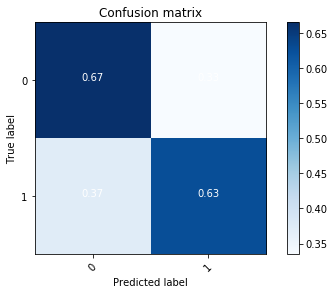

In [234]:
# Utilizing pipelines to Count Vectorize, TF-IDF transform, and run the classifier:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier()),])
text_clf.fit(X_train, y_train)
predicted_test = text_clf.predict(X_test)
predicted_train = text_clf.predict(X_train)
print("Stochastic Gradient Descent Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

### 7. Multinomial Naive Bayes Classifier

Multinomial Naive Bayes Results

Training Precision:  0.7869986168741355
Testing Precision:  0.621273166800967



Training Recall:  0.9584503088152723
Testing Recall:  0.7899590163934426



Training Accuracy:  0.848201642594166
Testing Accuracy:  0.6451104100946372



Training F1 Score:  0.8643037974683544
Testing F1 Score:  0.6955345060893099



Confusion matrix, without normalization


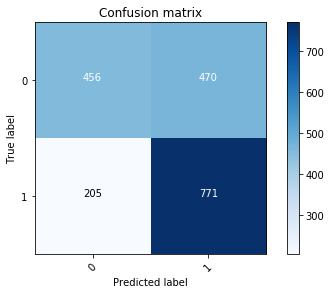




Normalized confusion matrix


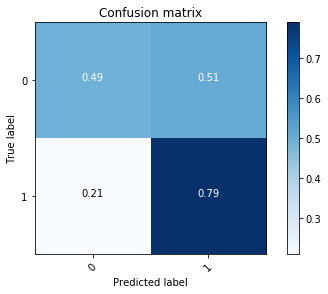

In [235]:
# Utilizing pipelines to Count Vectorize, TF-IDF transform, and run the classifier:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),])
text_clf.fit(X_train, y_train)
predicted_test = text_clf.predict(X_test)
predicted_train = text_clf.predict(X_train)
print("Multinomial Naive Bayes Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

<a id='Part_4'></a>

# Hyperparameter Tuning

In [236]:
#pipeline to pass to gridsearch
pipe = Pipeline([('cv', CountVectorizer()), ('tf', TfidfTransformer()), ('mnb', MultinomialNB())])
#parameters to pass to gridsearch
grid_params = {'cv__ngram_range': [(1,1), (1,2), (1,3)],
               'cv__max_df': np.linspace(0.1, 1, 10),
               'cv__binary': [True, False],
               'tf__norm': [None, 'l1', 'l2'],
               'mnb__alpha': np.linspace(0.5, 1.5, 3),
               'mnb__fit_prior': [True, False]}
# Utilizing GridSearchCV to scan all parameters and evaluate classifier performance with each parameter passed
gs = GridSearchCV(estimator=pipe, param_grid=grid_params, scoring='balanced_accuracy', cv=3, verbose=2, return_train_score = True)
gs.fit(X_train, y_train)
print("Best Score: ", gs.best_score_)
print("Best Params: ", gs.best_params_)

Multinomial Naive Bayes Results

Training Precision:  0.9983183856502242
Testing Precision:  0.6427350427350428



Training Recall:  1.0
Testing Recall:  0.7704918032786885



Training Accuracy:  0.9991503823279524
Testing Accuracy:  0.6624605678233438



Training F1 Score:  0.9991584852734923
Testing F1 Score:  0.700838769804287



Confusion matrix, without normalization


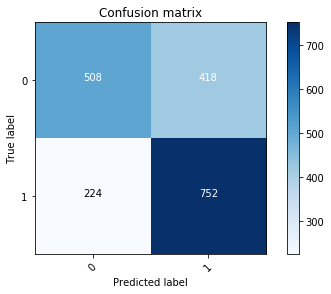




Normalized confusion matrix


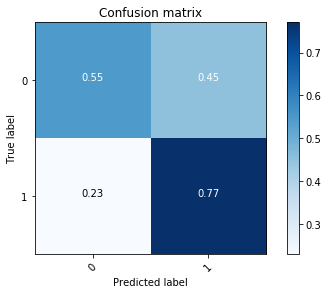

In [239]:
#implementing above parameters from gridsearch to our pipeline:
text_mnb = Pipeline([('vect', CountVectorizer(binary=False, max_df=0.1, ngram_range=(1,2))),
                     ('tfidf', TfidfTransformer(norm='l2')),
                     ('clf', MultinomialNB(alpha=0.5, fit_prior=True)),])
text_mnb.fit(X_train, y_train)
predicted_test = text_mnb.predict(X_test)
predicted_train = text_mnb.predict(X_train)
print("Multinomial Naive Bayes Results")
print("")
evaluate(y_train, predicted_train, y_test, predicted_test, class_names=class_names)

Based on our GridSearch, we have tuned our hyperparameters and have come up with an even better Accuracy, Precision and F1 Score, while the Recall score dropped slightly, overall though it's a good outcome:

* Prior Testing Accuracy:  0.6451104100946372

* New Testing Accuracy:  0.6624605678233438


* Prior Testing Recall:  0.7899590163934426

* New Testing Recall:  0.7704918032786885


* Prior Testing Precision:  0.621273166800967

* Testing Precision:  0.6427350427350428


* Prior Testing F1 Score:  0.6955345060893099

* New Testing F1 Score:  0.700838769804287

Not bad, but perhaps we can do better with some deep learning! 

# Final Classifier
### Saving final classifier to pickle

In [403]:
# Dump the trained classifier with Pickle
text_mnb_pkl_filename = 'Text_MNB.pkl'
# Open the file to save as pkl file
text_mnb_model_pkl = open(text_mnb_pkl_filename, 'wb')
pickle.dump(model4, text_mnb_model_pkl)
# Close the pickle instances
text_mnb_model_pkl.close()

# LSTM and GRU Neural Network to add to the fun:)

In [378]:
#splitting the data only containing the text and labels
X_train, X_test, y_train, y_test = train_test_split(final_df.selftext, final_df.labels)

In [379]:
#Tokenizing the text
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))

In [380]:
#Text to sequence function
def token_lists(X_train, X_test, tokenizer):
    
    list_tokenized_train = tokenizer.texts_to_sequences(X_train)
    list_tokenized_test = tokenizer.texts_to_sequences(X_test)

    return list_tokenized_train, list_tokenized_test

In [381]:
#Implementing the function
list_tokenized_train, list_tokenized_test = token_lists(X_train, X_test, tokenizer)

In [382]:
maxlen = 100
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
y_t = np.array(y_train)
y_te = np.array(y_test)

In [383]:
#Building the model
model = Sequential()
model.add(Embedding(20000, embedding_size))
model.add(GRU(50, return_sequences=True))
model.add(MaxPooling1D())
model.add(Conv1D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(64, 3, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(1, activation='sigmoid'))


model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(),
        metrics=['accuracy'])

    # fit model
hist = model.fit(X_t, y_t, validation_split=0.1,batch_size=32, epochs=10, verbose=2)


Train on 3672 samples, validate on 408 samples
Epoch 1/10
 - 29s - loss: 0.6972 - acc: 0.5025 - val_loss: 0.6945 - val_acc: 0.5686
Epoch 2/10
 - 11s - loss: 0.6639 - acc: 0.6021 - val_loss: 0.6623 - val_acc: 0.6078
Epoch 3/10
 - 11s - loss: 0.4810 - acc: 0.7922 - val_loss: 0.7163 - val_acc: 0.6152
Epoch 4/10
 - 11s - loss: 0.2556 - acc: 0.9093 - val_loss: 1.0560 - val_acc: 0.5809
Epoch 5/10
 - 10s - loss: 0.1288 - acc: 0.9562 - val_loss: 1.2886 - val_acc: 0.5760
Epoch 6/10
 - 11s - loss: 0.0751 - acc: 0.9728 - val_loss: 1.7143 - val_acc: 0.5907
Epoch 7/10
 - 11s - loss: 0.0515 - acc: 0.9831 - val_loss: 2.2008 - val_acc: 0.6005
Epoch 8/10
 - 11s - loss: 0.0413 - acc: 0.9869 - val_loss: 2.4530 - val_acc: 0.5539
Epoch 9/10
 - 11s - loss: 0.0279 - acc: 0.9921 - val_loss: 2.6296 - val_acc: 0.5858
Epoch 10/10
 - 11s - loss: 0.0497 - acc: 0.9867 - val_loss: 2.3992 - val_acc: 0.5907


Normalized confusion matrix


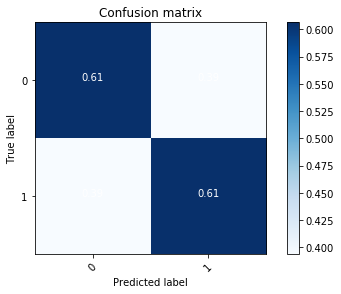

In [384]:
#Evaluating the model
y_pred = (model.predict(X_te, batch_size=1)>0.5)
cm = confusion_matrix(y_te, y_pred)
plot_confusion_matrix(cm, class_names, normalize=True)

In [385]:
#Building an LSTM Model
model2 = Sequential()
model2.add(Embedding(20000, embedding_size))
model2.add(LSTM(50, return_sequences=True))
model2.add(MaxPooling1D())
model2.add(Conv1D(64, 3, activation='relu', padding='same'))
model2.add(MaxPooling1D())
model2.add(Conv1D(64, 3, activation='relu', padding='same'))
model2.add(GlobalMaxPooling1D())
model2.add(Dropout(0.5))
model2.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model2.add(Dense(1, activation='sigmoid'))


model2.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(),
        metrics=['accuracy'])

    # fit model
hist = model2.fit(X_t, y_t, validation_split=0.1,batch_size=32, epochs=10, verbose=2)


Train on 3672 samples, validate on 408 samples
Epoch 1/10
 - 28s - loss: 0.6974 - acc: 0.5022 - val_loss: 0.6943 - val_acc: 0.5221
Epoch 2/10
 - 13s - loss: 0.6681 - acc: 0.5923 - val_loss: 0.6675 - val_acc: 0.5882
Epoch 3/10
 - 13s - loss: 0.4811 - acc: 0.7827 - val_loss: 0.8566 - val_acc: 0.5588
Epoch 4/10
 - 13s - loss: 0.2508 - acc: 0.9011 - val_loss: 0.9509 - val_acc: 0.5980
Epoch 5/10
 - 14s - loss: 0.1412 - acc: 0.9523 - val_loss: 1.3516 - val_acc: 0.6029
Epoch 6/10
 - 13s - loss: 0.0911 - acc: 0.9681 - val_loss: 1.5758 - val_acc: 0.5858
Epoch 7/10
 - 13s - loss: 0.0515 - acc: 0.9831 - val_loss: 2.5431 - val_acc: 0.5588
Epoch 8/10
 - 14s - loss: 0.0352 - acc: 0.9897 - val_loss: 2.3086 - val_acc: 0.5833
Epoch 9/10
 - 13s - loss: 0.0271 - acc: 0.9913 - val_loss: 3.2793 - val_acc: 0.5882
Epoch 10/10
 - 13s - loss: 0.0440 - acc: 0.9867 - val_loss: 2.4549 - val_acc: 0.5735


Normalized confusion matrix


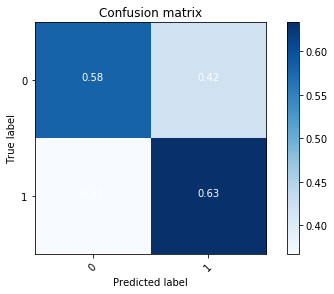

In [386]:
#Evaluating the LSTM Model
y_pred = (model2.predict(X_te, batch_size=1)>0.5)
cm = confusion_matrix(y_te, y_pred)
plot_confusion_matrix(cm, class_names, normalize=True)

In [389]:
# Building a Bidirectional GRU Model
model4 = Sequential()
model4.add(Embedding(20000, embedding_size))
model4.add(Bidirectional(GRU(50, return_sequences=True)))
model4.add(MaxPooling1D())
model4.add(Conv1D(64, 3, activation='relu', padding='same'))
model4.add(MaxPooling1D())
model4.add(Conv1D(64, 3, activation='relu', padding='same'))
model4.add(GlobalMaxPooling1D())
model4.add(Dropout(0.5))
model4.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model4.add(Dense(1, activation='sigmoid'))


model4.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(),
        metrics=['accuracy'])

    # fit model
hist = model4.fit(X_t, y_t, validation_split=0.1,batch_size=32, epochs=10, verbose=2)

Train on 3672 samples, validate on 408 samples
Epoch 1/10
 - 27s - loss: 0.6979 - acc: 0.4970 - val_loss: 0.6968 - val_acc: 0.4804
Epoch 2/10
 - 15s - loss: 0.6801 - acc: 0.5689 - val_loss: 0.6702 - val_acc: 0.6005
Epoch 3/10
 - 16s - loss: 0.5570 - acc: 0.7211 - val_loss: 0.6889 - val_acc: 0.6250
Epoch 4/10
 - 15s - loss: 0.3046 - acc: 0.8777 - val_loss: 0.9351 - val_acc: 0.6127
Epoch 5/10
 - 15s - loss: 0.1314 - acc: 0.9540 - val_loss: 1.4853 - val_acc: 0.6103
Epoch 6/10
 - 15s - loss: 0.0538 - acc: 0.9815 - val_loss: 2.2172 - val_acc: 0.5980
Epoch 7/10
 - 15s - loss: 0.0525 - acc: 0.9826 - val_loss: 2.1232 - val_acc: 0.6201
Epoch 8/10
 - 15s - loss: 0.0291 - acc: 0.9891 - val_loss: 2.4592 - val_acc: 0.6127
Epoch 9/10
 - 15s - loss: 0.0332 - acc: 0.9899 - val_loss: 2.4585 - val_acc: 0.5956
Epoch 10/10
 - 16s - loss: 0.0533 - acc: 0.9834 - val_loss: 2.1003 - val_acc: 0.6078


Normalized confusion matrix


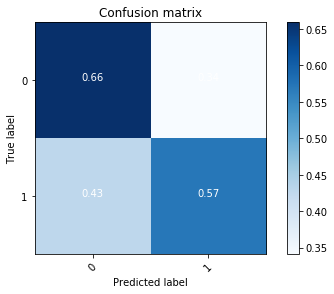

In [390]:
# Evaluating the model
y_pred = (model4.predict(X_te, batch_size=1)>0.5)
cm = confusion_matrix(y_te, y_pred)
plot_confusion_matrix(cm, class_names, normalize=True)

In [391]:
# Building a Bidirectional LSTM Model
model3 = Sequential()
model3.add(Embedding(20000, embedding_size))
model3.add(Bidirectional(LSTM(50, return_sequences=True)))
model3.add(MaxPooling1D())
model3.add(Conv1D(64, 3, activation='relu', padding='same'))
model3.add(MaxPooling1D())
model3.add(Conv1D(64, 3, activation='relu', padding='same'))
model3.add(GlobalMaxPooling1D())
model3.add(Dropout(0.5))
model3.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model3.add(Dense(1, activation='sigmoid'))


model3.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(),
        metrics=['accuracy'])

    # fit model
hist = model3.fit(X_t, y_t, validation_split=0.1,batch_size=32, epochs=10, verbose=2)

Train on 3672 samples, validate on 408 samples
Epoch 1/10
 - 30s - loss: 0.6970 - acc: 0.5193 - val_loss: 0.6985 - val_acc: 0.4804
Epoch 2/10
 - 20s - loss: 0.6747 - acc: 0.5806 - val_loss: 0.6524 - val_acc: 0.6152
Epoch 3/10
 - 21s - loss: 0.4895 - acc: 0.7802 - val_loss: 0.7152 - val_acc: 0.6152
Epoch 4/10
 - 19s - loss: 0.2508 - acc: 0.9036 - val_loss: 0.9713 - val_acc: 0.6054
Epoch 5/10
 - 21s - loss: 0.1172 - acc: 0.9575 - val_loss: 1.5309 - val_acc: 0.6029
Epoch 6/10
 - 21s - loss: 0.0705 - acc: 0.9769 - val_loss: 1.6717 - val_acc: 0.6127
Epoch 7/10
 - 19s - loss: 0.0422 - acc: 0.9869 - val_loss: 2.2876 - val_acc: 0.6103
Epoch 8/10
 - 20s - loss: 0.0256 - acc: 0.9913 - val_loss: 2.5536 - val_acc: 0.6005
Epoch 9/10
 - 19s - loss: 0.0248 - acc: 0.9929 - val_loss: 2.7567 - val_acc: 0.6005
Epoch 10/10
 - 20s - loss: 0.0199 - acc: 0.9948 - val_loss: 3.0999 - val_acc: 0.5907


Normalized confusion matrix


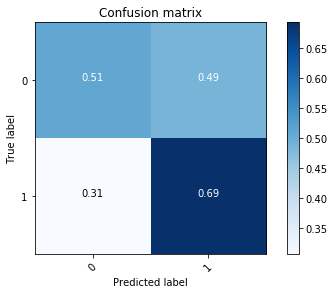

In [392]:
# Evaluating the Model
y_pred = (model3.predict(X_te, batch_size=1)>0.5)

cm = confusion_matrix(y_te, y_pred)
plot_confusion_matrix(cm, class_names, normalize=True)

In [397]:
# Rebuilding the Bidirectional GRU Model, adding additional Dropout Layers to prevent overfitting
model4 = Sequential()
model4.add(Embedding(20000, embedding_size))
model4.add(Bidirectional(GRU(50, return_sequences=True)))
model4.add(MaxPooling1D())
model4.add(Dropout(0.5))
model4.add(Conv1D(64, 3, activation='relu', padding='same'))
model4.add(MaxPooling1D())
model4.add(Dropout(0.5))
model4.add(Conv1D(64, 3, activation='relu', padding='same'))
model4.add(GlobalMaxPooling1D())
model4.add(Dropout(0.5))
model4.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l1(1e-4)))
model4.add(Dropout(0.5))
model4.add(Dense(1, activation='sigmoid'))


model4.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(),
        metrics=['accuracy'])

    # fit model
hist = model4.fit(X_t, y_t, validation_split=0.1,batch_size=32, epochs=10, verbose=2)

Train on 3672 samples, validate on 408 samples
Epoch 1/10
 - 31s - loss: 0.7199 - acc: 0.4973 - val_loss: 0.7158 - val_acc: 0.5270
Epoch 2/10
 - 17s - loss: 0.7157 - acc: 0.5035 - val_loss: 0.7135 - val_acc: 0.4804
Epoch 3/10
 - 16s - loss: 0.7117 - acc: 0.5169 - val_loss: 0.7108 - val_acc: 0.4877
Epoch 4/10
 - 16s - loss: 0.7038 - acc: 0.5458 - val_loss: 0.6985 - val_acc: 0.5368
Epoch 5/10
 - 17s - loss: 0.6285 - acc: 0.6702 - val_loss: 0.6577 - val_acc: 0.6373
Epoch 6/10
 - 16s - loss: 0.4517 - acc: 0.8113 - val_loss: 0.7048 - val_acc: 0.6324
Epoch 7/10
 - 17s - loss: 0.2545 - acc: 0.9115 - val_loss: 0.9543 - val_acc: 0.6250
Epoch 8/10
 - 17s - loss: 0.1291 - acc: 0.9611 - val_loss: 1.2597 - val_acc: 0.6275
Epoch 9/10
 - 16s - loss: 0.0751 - acc: 0.9831 - val_loss: 1.3801 - val_acc: 0.6250
Epoch 10/10
 - 16s - loss: 0.0612 - acc: 0.9847 - val_loss: 2.0180 - val_acc: 0.6201


Normalized confusion matrix


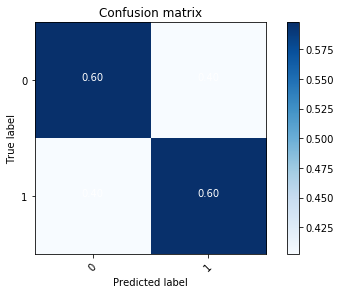

In [398]:
# Evaluating our model
y_pred = (model4.predict(X_te, batch_size=1)>0.5)

cm = confusion_matrix(y_te, y_pred)
plot_confusion_matrix(cm, class_names, normalize=True)

# Not that much better than our classifiers but still pretty impressive considering our highly imperfect dataset!

<a id='Part_5'></a>

# Final Model
### Saving final model to pickle

In [401]:

# Dump the trained decision tree classifier with Pickle
bgru_pkl_filename = 'Bidirectional_GRU.pkl'
# Open the file to save as pkl file
bgru_model_pkl = open(bgru_pkl_filename, 'wb')
pickle.dump(model4, bgru_model_pkl)
# Close the pickle instances
bgru_model_pkl.close()

<a id='Part_6'></a>

# Conclusions
* We have a decently well functioning model that can classify suicidal ideation in social media posts with ~66% accuracy. Considering the imperfect dataset we are working with, it is a pretty good model!

* Our relatively high recall value of 77% ensures that we miss as few suicidal posters as possible when implementing our model!

### Up Next... What if we add in additional features, including percentage of absolutist words used, post length, sentiment, subjectivity, and time of day posted? Will that improve our model?